In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
PROJECT_ROOT = Path.cwd().parents[0]
DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
FIG_DIR = RESULTS_DIR / "figures"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

train_edges = pd.read_csv(DATA_DIR / "train_edges.csv")
test_edges  = pd.read_csv(DATA_DIR / "test_edges.csv")
core_nodes  = set(map(int, (DATA_DIR / "core_nodes.txt").read_text().splitlines()))

print("Train edges:", len(train_edges))
print("Test edges:", len(test_edges))
print("Core nodes:", len(core_nodes))

Train edges: 20778
Test edges: 3867
Core nodes: 3942


In [3]:
G = nx.Graph()
G.add_edges_from(train_edges[["u", "v"]].itertuples(index=False, name=None))
G_core = G.subgraph(core_nodes).copy()

E_train = set(tuple(sorted(e)) for e in G_core.edges())
E_test  = set(tuple(sorted(e)) for e in test_edges[["u","v"]].itertuples(index=False, name=None))

print("G_core nodes:", G_core.number_of_nodes())
print("G_core edges:", G_core.number_of_edges())

G_core nodes: 3942
G_core edges: 10670


In [ ]:
# Prefer the richest version (with community features) if it exists
scores_path1 = RESULTS_DIR / "lp_scores_with_community_features.csv"
scores_path2 = RESULTS_DIR / "lp_candidate_scores.csv"



if scores_path1.exists():
    scores = pd.read_csv(scores_path1)
    print("Loaded:", scores_path1.name, scores.shape)
elif scores_path2.exists():
    scores = pd.read_csv(scores_path2)
    print("Loaded:", scores_path2.name, scores.shape)
else:
    raise FileNotFoundError("No candidate scores file found in results/. Save it from previous notebooks first.")

# Ensure required columns exist
required_cols = {"u", "v"}
missing = required_cols - set(scores.columns)
if missing:
    raise ValueError(f"Missing columns in scores file: {missing}")

scores.head()

Loaded: lp_candidate_scores.csv (63841, 6)


,u,v,CN,Jaccard,AA,PA
0,14103,39176,1,0.111111,0.455120,16
1,14975,45521,1,0.090909,0.296974,32
2,16619,26304,1,0.043478,0.360674,144
3,42304,50878,1,0.071429,0.389871,56
4,12561,35480,1,0.055556,0.306928,90


In [5]:
cand_set = set((min(u,v), max(u,v)) for u, v in zip(scores["u"], scores["v"]))
coverage = sum(1 for e in E_test if e in cand_set) / len(E_test)

n_new = len(E_test)
core_size = G_core.number_of_nodes()
m_old = len(E_train)
random_prob = n_new / ((core_size * (core_size - 1) // 2) - m_old)

print(f"Candidate coverage: {coverage:.6f}")
print(f"Random baseline probability: {random_prob:.10f}")
print(f"n_new (top-n size): {n_new}")

Candidate coverage: 0.734161
Random baseline probability: 0.0004985148
n_new (top-n size): 3867


In [6]:
from node2vec import Node2Vec

c:\Users\pc\OneDrive\Bureau\graph-analytics-final-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# node2vec hyperparameters (CPU-friendly)
DIM = 64
WALK_LENGTH = 20
NUM_WALKS = 10
WINDOW = 10
MIN_COUNT = 1
BATCH_WORDS = 256
WORKERS = 1  # safer on Windows; can try 2 if stable

# p, q from Lecture 5:
# q < 1 => more DFS-like (structural), q > 1 => more BFS-like (community/local)
P = 1.0
Q = 0.5

n2v = Node2Vec(
    G_core,
    dimensions=DIM,
    walk_length=WALK_LENGTH,
    num_walks=NUM_WALKS,
    p=P,
    q=Q,
    workers=WORKERS,
    seed=42
)

model = n2v.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

print("node2vec training done.")

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


node2vec training done.


In [8]:
# Build embedding dict (node2vec stores node ids as strings in gensim)
emb = {}
for node in G_core.nodes():
    key = str(node)
    if key in model.wv:
        emb[node] = model.wv[key]

print("Embeddings available for nodes:", len(emb), "/", G_core.number_of_nodes())

Embeddings available for nodes: 3942 / 3942


In [9]:
def safe_dot(u, v):
    zu = emb.get(u)
    zv = emb.get(v)
    if zu is None or zv is None:
        return 0.0
    return float(np.dot(zu, zv))

def safe_cos(u, v):
    zu = emb.get(u)
    zv = emb.get(v)
    if zu is None or zv is None:
        return 0.0
    nu = np.linalg.norm(zu)
    nv = np.linalg.norm(zv)
    if nu == 0 or nv == 0:
        return 0.0
    return float(np.dot(zu, zv) / (nu * nv))

In [10]:
scores["n2v_dot_p1_q05"] = [safe_dot(u, v) for u, v in tqdm(scores[["u","v"]].itertuples(index=False, name=None), total=len(scores), desc="Scoring node2vec dot")]
scores["n2v_cos_p1_q05"] = [safe_cos(u, v) for u, v in tqdm(scores[["u","v"]].itertuples(index=False, name=None), total=len(scores), desc="Scoring node2vec cosine")]

scores[["n2v_dot_p1_q05", "n2v_cos_p1_q05"]].describe()

Scoring node2vec cosine: 100%|██████████| 63841/63841 [00:02<00:00, 21855.48it/s]


,n2v_dot_p1_q05,n2v_cos_p1_q05
count,63841.000000,63841.000000
mean,7.079753,0.566554
std,3.135141,0.141308
min,1.563535,0.147213
25%,4.959966,0.463425
50%,6.337442,0.551206
75%,8.403948,0.655505
max,34.609283,0.999641


In [11]:
def topn_accuracy(scores_df, score_col, E_test, n_new, ascending=False):
    df = scores_df.sort_values(score_col, ascending=ascending)
    top = list(zip(df["u"].values[:n_new], df["v"].values[:n_new]))
    correct = sum(1 for e in top if (min(e), max(e)) in E_test)
    return correct / n_new, correct

In [12]:
candidate_methods = ["AA", "n2v_dot_p1_q05", "n2v_cos_p1_q05"]

# Add your best community-aware combo if available
if "AA_plus_0.25_same" in scores.columns:
    candidate_methods.insert(1, "AA_plus_0.25_same")

rows = []
for col in candidate_methods:
    acc, correct = topn_accuracy(scores, col, E_test, n_new, ascending=False)
    rows.append((col, acc, correct))

emb_res_df = pd.DataFrame(rows, columns=["Method", "Top-n accuracy", "Correct in top-n"])
emb_res_df["Improvement_vs_Random"] = emb_res_df["Top-n accuracy"] / random_prob
emb_res_df["Normalized_over_Coverage"] = emb_res_df["Top-n accuracy"] / coverage
emb_res_df = emb_res_df.sort_values("Top-n accuracy", ascending=False)

emb_res_df

,Method,Top-n accuracy,Correct in top-n,Improvement_vs_Random,Normalized_over_Coverage
0,AA,0.357642,1383,717.414125,0.487143
2,n2v_cos_p1_q05,0.277993,1075,557.642938,0.378654
1,n2v_dot_p1_q05,0.243082,940,487.613360,0.331103


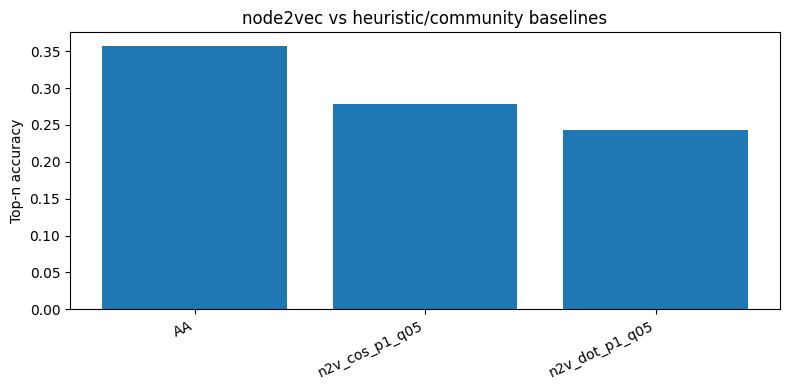

In [13]:
plt.figure(figsize=(8,4))
plt.bar(emb_res_df["Method"], emb_res_df["Top-n accuracy"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("Top-n accuracy")
plt.title("node2vec vs heuristic/community baselines")
plt.tight_layout()
plt.savefig(FIG_DIR / "node2vec_vs_baselines_topn.png", dpi=250)
plt.show()

In [14]:
def train_node2vec_and_score(G_core, scores_df, p=1.0, q=1.0, dim=64, walk_length=20, num_walks=10, window=10, workers=1):
    n2v = Node2Vec(
        G_core,
        dimensions=dim,
        walk_length=walk_length,
        num_walks=num_walks,
        p=p,
        q=q,
        workers=workers,
        seed=42
    )
    model = n2v.fit(window=window, min_count=1, batch_words=256)

    emb_local = {}
    for node in G_core.nodes():
        key = str(node)
        if key in model.wv:
            emb_local[node] = model.wv[key]

    dot_scores = []
    for u, v in scores_df[["u","v"]].itertuples(index=False, name=None):
        zu = emb_local.get(u)
        zv = emb_local.get(v)
        if zu is None or zv is None:
            dot_scores.append(0.0)
        else:
            dot_scores.append(float(np.dot(zu, zv)))
    return np.array(dot_scores)

In [15]:
sweep_results = []
for q_val in [0.5, 1.0, 2.0]:
    col = f"n2v_dot_p1_q{str(q_val).replace('.', '')}"
    print(f"Training node2vec for q={q_val} ...")
    scores[col] = train_node2vec_and_score(G_core, scores, p=1.0, q=q_val, workers=1)

    acc, correct = topn_accuracy(scores, col, E_test, n_new, ascending=False)
    sweep_results.append((col, q_val, acc, correct, acc / random_prob, acc / coverage))

n2v_sweep_df = pd.DataFrame(
    sweep_results,
    columns=["Method", "q", "Top-n accuracy", "Correct in top-n", "Improvement_vs_Random", "Normalized_over_Coverage"]
).sort_values("Top-n accuracy", ascending=False)

n2v_sweep_df

Training node2vec for q=0.5 ...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Training node2vec for q=1.0 ...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Training node2vec for q=2.0 ...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


,Method,q,Top-n accuracy,Correct in top-n,Improvement_vs_Random,Normalized_over_Coverage
1,n2v_dot_p1_q10,1.0,0.245668,950,492.800736,0.334625
0,n2v_dot_p1_q05,0.5,0.243082,940,487.613360,0.331103
2,n2v_dot_p1_q20,2.0,0.241014,932,483.463459,0.328285


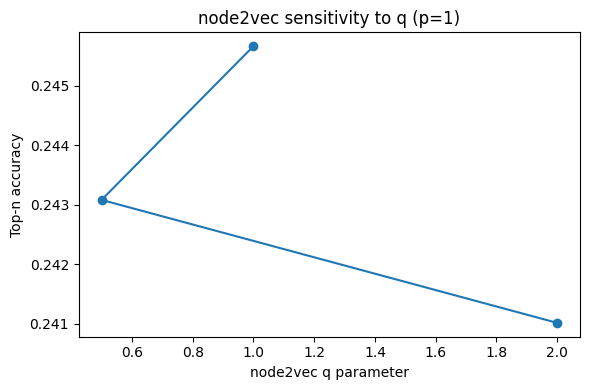

In [16]:
plt.figure(figsize=(6,4))
plt.plot(n2v_sweep_df["q"], n2v_sweep_df["Top-n accuracy"], marker="o")
plt.xlabel("node2vec q parameter")
plt.ylabel("Top-n accuracy")
plt.title("node2vec sensitivity to q (p=1)")
plt.tight_layout()
plt.savefig(FIG_DIR / "node2vec_q_sweep.png", dpi=250)
plt.show()

In [17]:
scores.to_csv(RESULTS_DIR / "lp_scores_with_embeddings.csv", index=False)
emb_res_df.to_csv(RESULTS_DIR / "embeddings_vs_baselines_results.csv", index=False)
if "n2v_sweep_df" in globals():
    n2v_sweep_df.to_csv(RESULTS_DIR / "node2vec_sweep_results.csv", index=False)

print("Saved embedding results.")

Saved embedding results.
